In [1]:
!pip install pafy youtube-dl moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.0 MB/s eta 0:00:00


In [2]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

--2023-09-22 09:38:12--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  14.5MB/s    in 3m 30s  

2023-09-22 09:41:43 (14.7 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [5]:
%%capture

!unrar x UCF50.rar

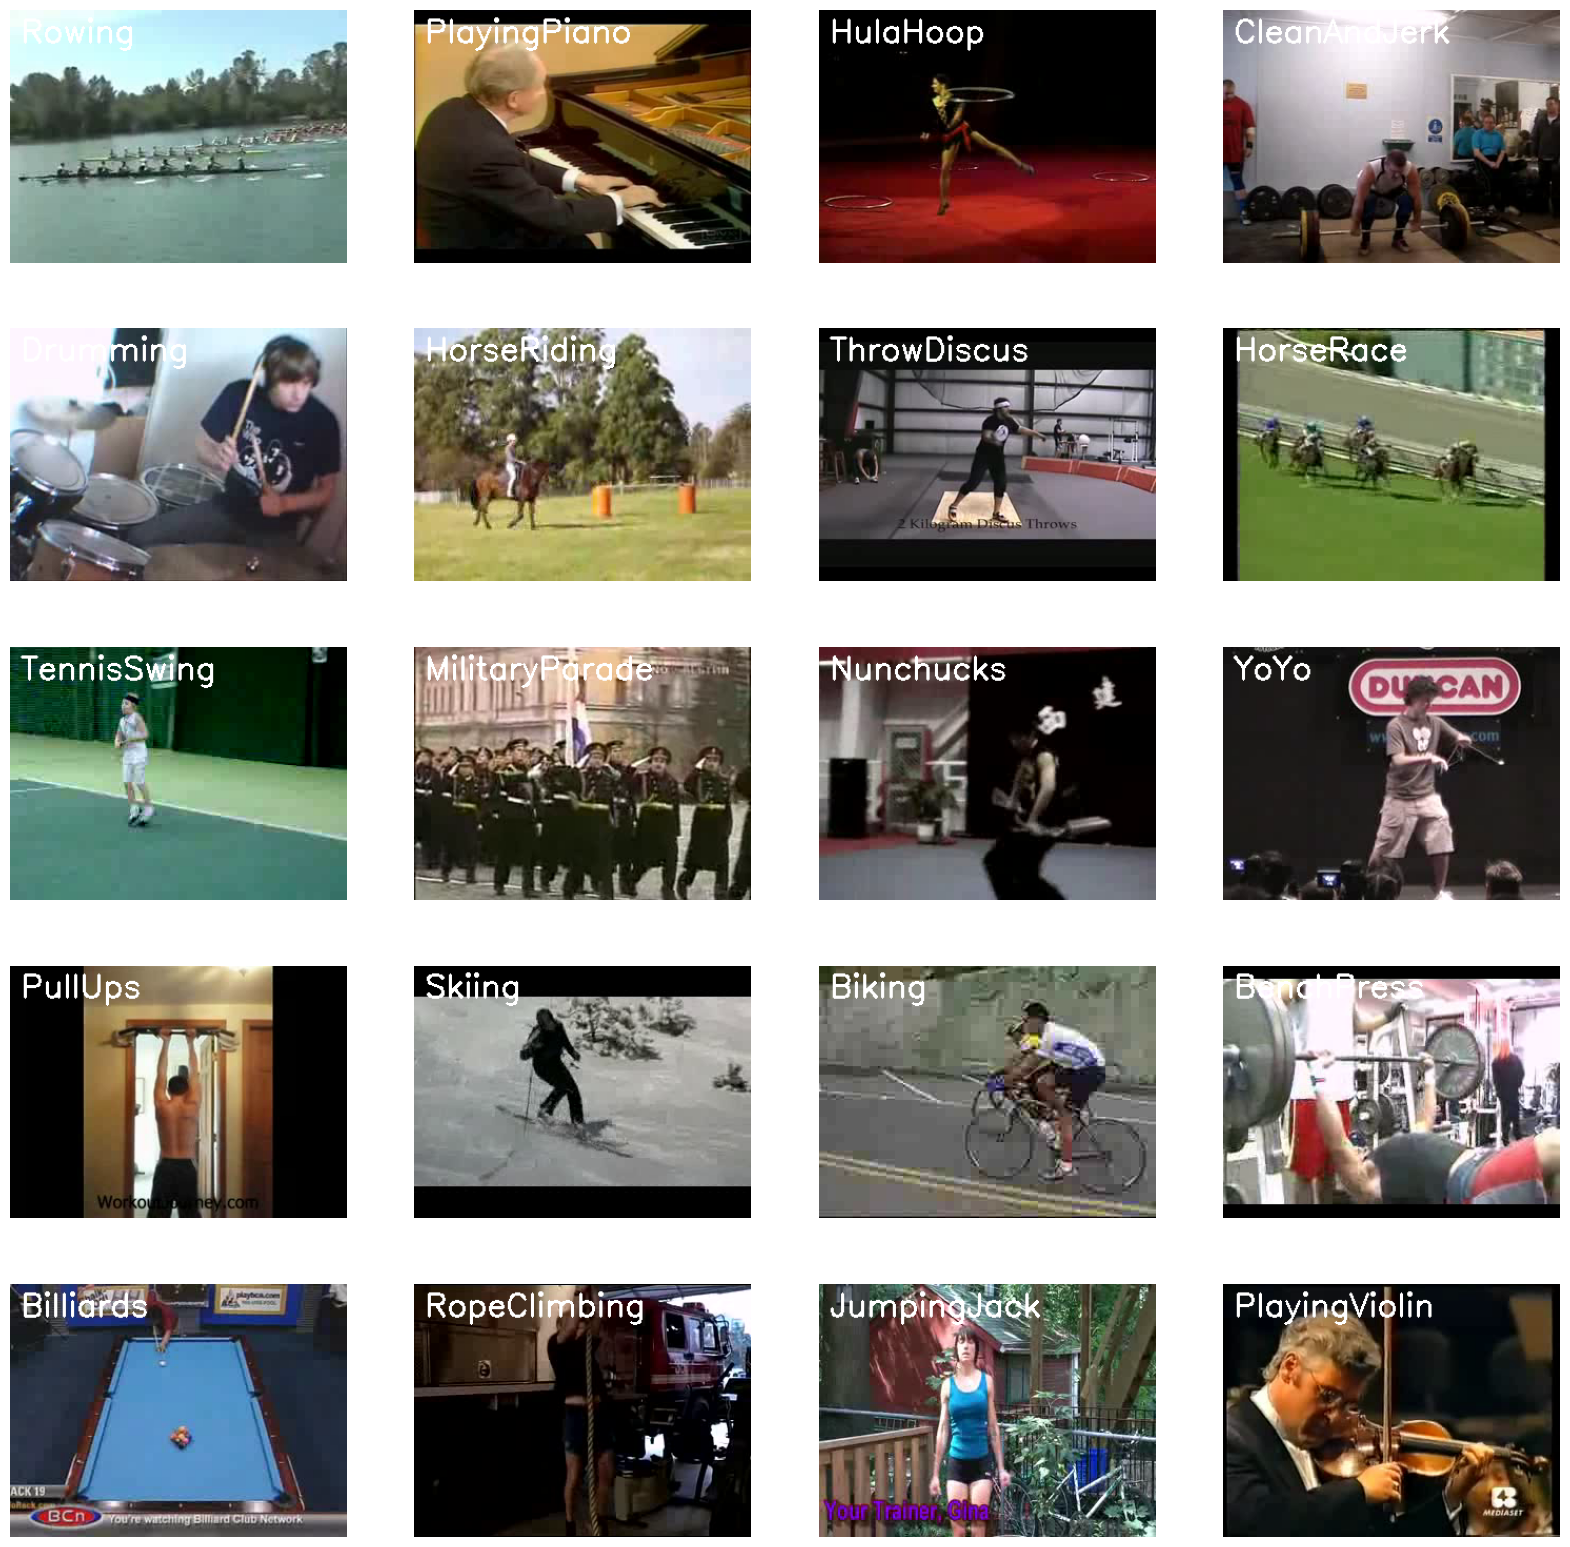

In [6]:
plt.figure(figsize = (20,20))
all_classes_names = os.listdir('UCF50')
random_range = random.sample(range(len(all_classes_names)),20)

for counter,random_index in enumerate(random_range,1):
  selected_class_name = all_classes_names[random_index]
  video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')
  selected_video_file_name = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')
  _, bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 2)

  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')

In [7]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]


In [8]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)

  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    success, frame = video_reader.read()

    if not success:
      break
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    normalized_frame = resized_frame/255

    frames_list.append(normalized_frame)

  video_reader.release()
  return frames_list


In [9]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))


    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      frames = frames_extraction(video_file_path)


      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  features = np.asarray(features)
  labels = np.array(labels)

  return features, labels, video_files_paths

In [10]:
features, labels, video_files_paths = create_dataset()

In [11]:
print(len(features))
print(len(labels))
print(len(video_files_paths))

487
487
487


In [12]:
one_hot_encoded_labels = to_categorical(labels)

In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=0.25, shuffle = True,
                                                                            random_state=seed_constant)

In [19]:
def create_LRCN_model():

  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),
                            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))

  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))


  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))

  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))


  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))

  model.add(TimeDistributed(MaxPooling2D((2,2))))
  #model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()

  return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_29 (TimeD  (None, 20, 4, 4, 32)     

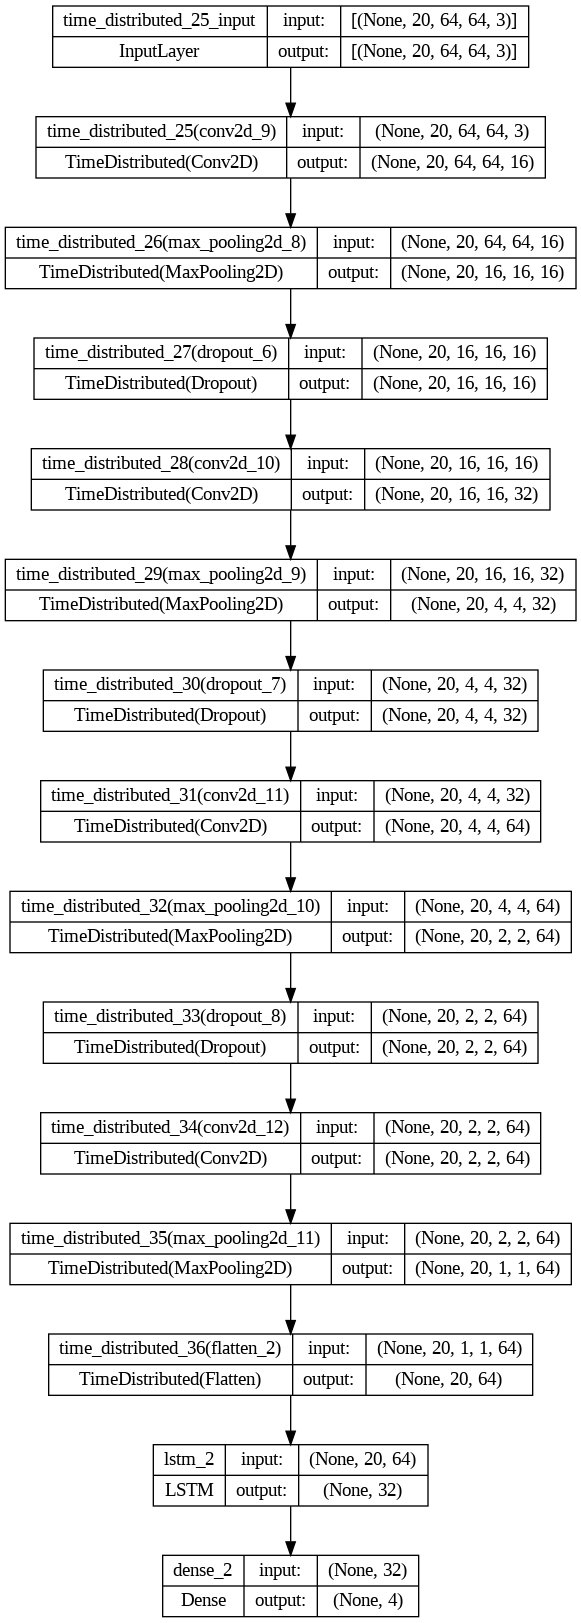

In [20]:
LRCN_model = create_LRCN_model()

plot_model(LRCN_model, to_file='LRCN_model_structure.png', show_shapes = True, show_layer_names = True)

In [23]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

LRCN_model_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size= 4,
                                    shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 17s 32ms/step - loss: 1.3921 - accuracy: 0.3288 - val_loss: 1.3559 - val_accuracy: 0.4247
Epoch 2/70
73/73 [==============================] - 1s 11ms/step - loss: 1.3033 - accuracy: 0.3836 - val_loss: 1.2849 - val_accuracy: 0.3699
Epoch 3/70
73/73 [==============================] - 1s 11ms/step - loss: 1.1138 - accuracy: 0.5240 - val_loss: 1.0604 - val_accuracy: 0.5616
Epoch 4/70
73/73 [==============================] - 1s 11ms/step - loss: 0.9658 - accuracy: 0.6130 - val_loss: 0.9439 - val_accuracy: 0.6986
Epoch 5/70
73/73 [==============================] - 1s 12ms/step - loss: 0.8712 - accuracy: 0.6404 - val_loss: 0.8055 - val_accuracy: 0.7260
Epoch 6/70
73/73 [==============================] - 1s 12ms/step - loss: 0.7650 - accuracy: 0.7021 - val_loss: 0.7521 - val_accuracy: 0.7534
Epoch 7/70
73/73 [==============================] - 1s 11ms/step - loss: 0.7346 - accuracy: 0.7158 - val_loss: 0.7683 - val_accuracy: 0.6164
Epoch 8/70
7

In [24]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 80ms/step - loss: 0.2086 - accuracy: 0.9426


In [26]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

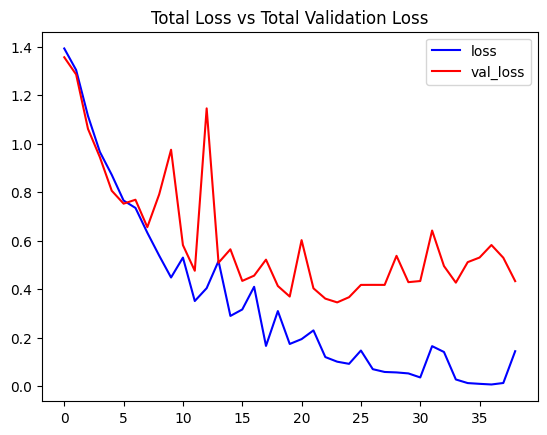

In [27]:
plot_metric(LRCN_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

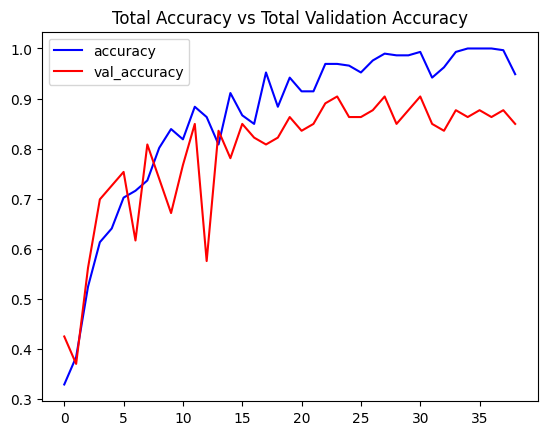

In [28]:
plot_metric(LRCN_model_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
#model_file_name = "LRCN_model_action_detection.h5"
#LRCN_model.save(model_file_name)